In [121]:
import csv
import re
import json

import geopandas as gpd

import shapely

from geojson import Point, Feature, FeatureCollection, dump, MultiPoint

## Process the records into GeoJson

In [70]:
records = []

with open('DATA MASTER-dh-copy-v11-2024-09-02.csv', encoding='utf-8-sig') as file:
    reader = csv.DictReader(file)
    for row in reader:
        records.append(row)
    file.close()    

In [71]:
list(records[0].keys())

['UUID',
 '\ufeffTitle',
 'Memory Mapper Title (keywords to identify the project) (should include the research content',
 'Project Location - In London',
 'Date',
 'Link',
 'Identification- DOI/URL/ISBN/Reference no.',
 'Authors',
 'London Authors',
 'Other Author (National+International)',
 'Department',
 'Abstract',
 'Partners',
 'Partnership Location - In London',
 'Partnership',
 'Policy Sources////Citations ( from Overton)',
 'Policy source subcategory',
 'Partnership 1',
 'Partnership 2',
 'Partnership 3',
 'Partnership 4',
 'Filter 2 (Themes)',
 'Funder 1',
 'Funder 2',
 'Funder 3',
 'Source',
 'Output type']

In [72]:
for r in records:
    r['Title'] = r['\ufeffTitle']
    del r['\ufeffTitle']

In [74]:
features = []

for row in records:
    points = []
    clean = ''
    for string in row['Project Location - In London'].split('\n'):
        res = re.search(r'\((-\d+|\d+)\d+.\d+,(-\d+|\d+).\d+\)', string)
        if (res):
            clean = re.sub(r'\((-\d+|\d+)\d+.\d+,(-\d+|\d+).\d+\)', '', string)
            coord_string = re.sub(r'\(|\)', '', res[0])
            coords = tuple([float(i) for i in coord_string.split(',')])
            p = Point((coords[1], coords[0]))
            points.append(p)
    geom = MultiPoint(points)
    
    #partner_types = [row['Partnership 1'], row['Partnership 2'], row['Partnership 3'], row['Partnership 4']]
    #funders = [row['Funder 1'], row['Funder 2'], row['Funder 3']]
    
    properties = {}
    
    for key, value in row.items():
        properties[key] = value
    
    f = Feature(geometry=geom, properties=properties,
    )
    features.append(f)

In [75]:
collection = FeatureCollection(features)

In [76]:
with open('./data-master-research-locations-v11-2024-08-02.geojson', 'w') as file:
    dump(collection, file)
    file.close()

## Create a graph...

In [21]:
import networkx as nx

In [28]:
g = nx.Graph()

for r in records:
    if r['Department'] == '':
        continue
    
    department = r['Department']
    
    if department not in g.nodes():
        g.add_node(department, node_type='department')
    
    p_types = [r['Partnership 1'], r['Partnership 2'], r['Partnership 3'], r['Partnership 4']]
    funders = [r['Funder 1'], r['Funder 2'], r['Funder 3']]
    
    #for p in p_types:
    #    if p == '':
    #        continue
    #    if p not in g.nodes():
    #        g.add_node(p, node_type='partnership')
    #    g.add_edge(department, p)
    
    for f in funders:
        if f == '':
            continue
        if f not in g.nodes():
            g.add_node(f, node_type='funder')
        g.add_edge(department, f)
        
    #if r['Filter 2 (Themes)'] != '':
    #    subject = r['Filter 2 (Themes)']
    #    if subject not in g.nodes():
    #        g.add_node(subject, node_type='research area')
    #    g.add_edge(department, subject)

In [29]:
nx.write_gexf(g, 'departments-funders-network-v1-2024-07-11.gexf')

In [ ]:
# Again, but source, target, value csv

In [39]:
edges = []
points = []

for r in records:
    if r['Department'] == '':
        continue
    
    department = r['Department']
    
    point = {'ID': department, 'Group': 'A'}
    
    if point not in points:
        points.append(point)
    
    p_types = [r['Partnership 1'], r['Partnership 2'], r['Partnership 3'], r['Partnership 4']]
    
    for p in p_types:
        
        if p == '':
            continue

        source_target_pair = [x for x in edges if x['source'] == department and x['target'] == p]

        if len(source_target_pair):
            source_target_pair[0]['value'] += 1
        else:
            edge = {'source': department, 'target': p, 'value': 1}
            edges.append(edge)

        point = {'ID': p, 'Group': 'B'}

        if point not in points:
            points.append(point)
            
            

In [40]:
with open('department-to-partnership-types-edges-v1-2024-07-11.csv', 'w') as file:
    writer = csv.DictWriter(file, fieldnames=list(edges[0].keys()))
    writer.writeheader()
    for row in edges:
        writer.writerow(row)
    file.close()

In [41]:
with open('department-to-partnership-types-points-v1-2024-07-11.csv', 'w') as file:
    writer = csv.DictWriter(file, fieldnames=list(points[0].keys()))
    writer.writeheader()
    for row in points:
        writer.writerow(row)
    file.close()

## Bring in London Boroughs

In [77]:
bartlett_data = gpd.read_file('./data-master-research-locations-v11-2024-08-02.geojson')

In [93]:
len(bartlett_data)

760

In [80]:
boroughs = gpd.read_file('/Users/djch21/Documents/UCL/Bartlett Activity Mapping/Data/bil-data/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')

<Axes: >

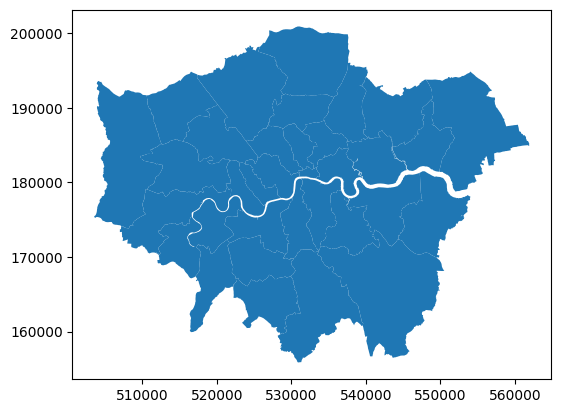

In [81]:
boroughs.plot()

In [84]:
boroughs = boroughs.to_crs(epsg=4326)

In [85]:
bartlett_data.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [86]:
boroughs.crs == bartlett_data.crs

True

In [87]:
# Join the Boroughs data using a point-in-polygon query - each record will now have the name of the associated Borough with it
join_left_df = bartlett_data.sjoin(boroughs, how='left')

In [89]:
len(join_left_df)

802

In [91]:
join_left_df.to_file('bartlett-data-with-boroughs-v1-2024-09-02.geojson', driver='GeoJSON')

/Users/djch21/Code/venv/jupyter/lib/python3.11/site-packages/pyogrio/geopandas.py:523: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  has_z_arr = geometry[geometry.notna() & (~geometry.is_empty)].has_z


In [99]:
# Reimport the JSON and save as a CSV - null geometries throw the 'CSV' write option for GeoPandas

bil_with_boroughs_json = json.load(open('./bartlett-data-with-boroughs-v1-2024-09-02.geojson'))

In [103]:
bil_with_boroughs = []

for f in bil_with_boroughs_json['features']:
    bil_with_boroughs.append(f['properties'])

In [104]:
bil_with_boroughs[0]

{'UUID': 'e5dc5aaeefb3530d03f5ad5b6a85d75a',
 'Memory Mapper Title (keywords to identify the project) (should include the research content': '"Real" wages? Contractors, workers, and pay in London building trades, 1650-1800',
 'Project Location - In London': "St Paul's Cathedral (51.5137871,-0.0984506) \nSt James Garlickhythe (51.5111244,-0.0936711) \nGreenwich Hospital (51.483587,-0.007198) \nWestminster Abbey (51.499399,-0.127391)\nMiddle Temple (51.51235580444336,-0.1110706701874733)\nBridge House (51.504962,-0.087651) \nWestminster Bridge (51.5008659362793,-0.12243890017271042) \nBlenheim Estate (51.454215,-0.123179)",
 'Date': '2017',
 'Link': 'https://onlinelibrary.wiley.com/doi/abs/10.1111/ehr.12491',
 'Identification- DOI/URL/ISBN/Reference no.': '10.1111/ehr.12491',
 'Authors': 'Judy Z Stephenson ',
 'London Authors': '',
 'Other Author (National+International)': '',
 'Department': 'Bartlett School of Sustainable Construction (51.521897,-0.134542)',
 'Abstract': 'Existing serie

## The above only brought in some of the points - the main research locations; it would be better to give each record a list of boroughs with which it is associated.

In [118]:
# Method: 
# 1. Import the boroughs to Geopandas
# 2. Iterate over each one and make a new geodataframe which is then saved as a geojson snippet in a list
# 3. Iterate over the bartlett data, extracting the points as above, and use shapely to test whether they're in a borough
# 4. If they are, add it to a list of boroughs for each record, which is then appended to the record

boroughs = gpd.read_file('/Users/djch21/Documents/UCL/Bartlett Activity Mapping/Data/bil-data/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')

In [119]:
boroughs = boroughs.to_crs(epsg=4326)

In [157]:
records = []

with open('DATA MASTER-dh-copy-v11-2024-09-02.csv', encoding='utf-8-sig') as file:
    reader = csv.DictReader(file)
    for row in reader:
        records.append(row)
    file.close() 

In [158]:
features = []

for row in records:
    points = []
    clean = ''
    for string in row['Project Location - In London'].split('\n'):
        res = re.search(r'\((-\d+|\d+)\d+.\d+,(-\d+|\d+).\d+\)', string)
        if (res):
            clean = re.sub(r'\((-\d+|\d+)\d+.\d+,(-\d+|\d+).\d+\)', '', string)
            coord_string = re.sub(r'\(|\)', '', res[0])
            coords = tuple([float(i) for i in coord_string.split(',')])
            p = Point((coords[1], coords[0]))
            points.append(p)
    geom = MultiPoint(points)
    
    # now test each point to see if it's in a London borough
    
    brghs = [] # don't clash the variable names...
    
    for p in points:
        for b in boroughs.iterrows():
            poly = b[1]['geometry']
            point = shapely.from_geojson(json.dumps(p))
    
            if shapely.contains(poly, point):
                brghs.append(b[1]['NAME'])
    
    #partner_types = [row['Partnership 1'], row['Partnership 2'], row['Partnership 3'], row['Partnership 4']]
    #funders = [row['Funder 1'], row['Funder 2'], row['Funder 3']]
    
    properties = {}
    
    for key, value in row.items():
        properties[key] = value
    
    properties['boroughs'] = list(set(brghs))
    
    f = Feature(geometry=geom, properties=properties,
    )
    features.append(f)

In [140]:
features[0]['properties']['boroughs']

['Lambeth', 'City of London', 'Southwark', 'Greenwich', 'Westminster']

In [159]:
collection = FeatureCollection(features)

#with open('./data-master-research-locations-v11-2024-09-09.geojson', 'w') as file:
#    dump(collection, file)
#    file.close()

In [161]:
# convert to csv

csv_data= []

for f in collection['features']:
    copied = dict(f)
    row = copied['properties']
    copied['properties'] = {}
    geom = json.dumps(copied)
    row['geometry'] = geom
    csv_data.append(row)
    

In [164]:
with open('./data-master-research-locations-v11-2024-09-09.csv', 'w') as file:
    writer = csv.DictWriter(file, fieldnames=list(csv_data[0].keys()))
    writer.writeheader()
    for row in csv_data:
        writer.writerow(row)
    file.close()

## Visualise...

In [166]:
borough_counts = {}

for rec in csv_data:
    for b in rec['boroughs']:
        if b not in borough_counts:
            borough_counts[b] = 1
        else:
            borough_counts[b] += 1

In [174]:
borough_counts_tidy = []

for key, value in borough_counts.items():
    row = {'borough': key, 'count': value}
    borough_counts_tidy.append(row)

In [169]:
import plotly.express as px
import pandas as pd

In [183]:
b_counts = pd.DataFrame(data=borough_counts_tidy)

In [184]:
b_counts = b_counts.sort_values(by='count', ascending=False)

In [185]:
fig = px.bar(b_counts, x='borough', y='count')

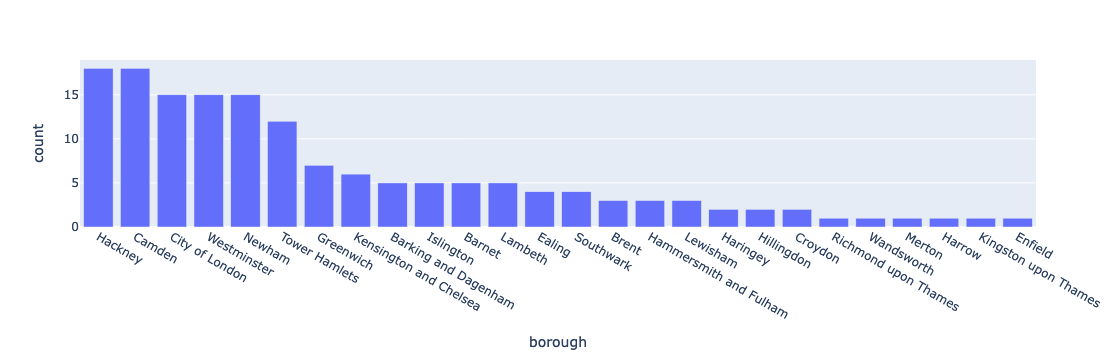

In [186]:
fig.show()